# A simple test for better understanding the dynamics

In [249]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision
import torch.nn.functional as F
from PIL import Image

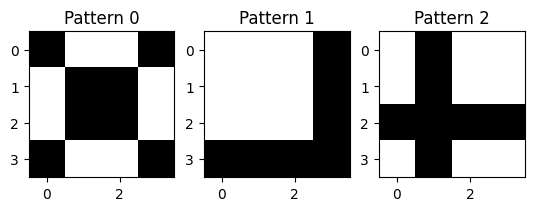

In [5]:
# Characteristics of ours inputs
size_square = 4
n_input = size_square ** 2

# Input patterns
pattern_0 = [0, 3, 5, 6, 9, 10, 12, 15]
pattern_1 = [3, 7, 11, 12, 13, 14, 15]
pattern_2 = [1, 5, 8, 9, 10, 11, 13]
n_patterns = 3 # which is also the class number
all_patterns = [pattern_0, pattern_1, pattern_2]

input_pattern = np.zeros((n_patterns, n_input))

# Program and plot patterns as images
fig_pattern, ax_pattern = plt.subplots(1, n_patterns)
for p in range(n_patterns):
    pattern = all_patterns[p]
    input_pattern[p, pattern] = 1
    ax_pattern[p].imshow(input_pattern[p, :].reshape(size_square, size_square), cmap=cm.binary)
    ax_pattern[p].set_title(f'Pattern {p}')

In [89]:
# Define the image dataset
class three_patterns(Dataset):
    def __init__(self, x, y, input_size, noise_scale, rept, seed, transform=None, target_transform=None):
        self.rng = np.random.RandomState(seed)
        self.transform = transform
        self.target_transform = target_transform
        add_noise = []
        noise_data = []
        labels = []
        for i in range(rept):
            for j in range(len(y)):
                noise = self.rng.rand(input_size)*noise_scale
                add_noise.append(noise)
                noise_data.append(x[j,:] + noise)
                labels.append(y[j])
        self.add_noise = add_noise
        self.data = noise_data
        self.targets = labels

    def __getitem__(self, item):
        img, label = self.data[item], self.targets[item]
        img = Image.fromarray(img)
#         print(img.shape())
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            label = self.target_transform(label)
        return img, label

    def __len__(self):
        return len(self.targets)
    
class ReshapeTransformTarget:
    def __init__(self, number_classes):
        self.number_classes = number_classes

    def __call__(self, target):
        target = torch.tensor(target).unsqueeze(0).unsqueeze(1)
        target_onehot = torch.zeros((1, self.number_classes))

        return target_onehot.scatter_(1, target.long(), 1).squeeze(0)
    
class ReshapeTransform:
    def __init__(self, new_size):
        self.new_size = new_size

    def __call__(self, img):
        return torch.reshape(img, self.new_size)

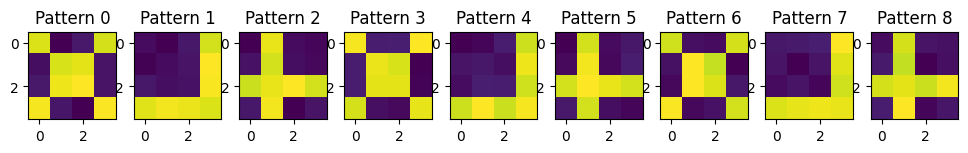

In [128]:
# Load the data
transform_data = [torchvision.transforms.ToTensor(), ReshapeTransform((-1,))]
train_set = three_patterns(input_pattern, range(n_patterns), 16, 0.1, 
                           rept=3, seed=40, transform=torchvision.transforms.Compose(transform_data), 
                           target_transform=ReshapeTransformTarget(n_patterns))

fig_data, ax_data = plt.subplots(1, len(train_set))
for p in range(len(train_set)):
    ax_data[p].imshow(train_set.data[p].reshape(size_square, size_square))
    ax_data[p].set_title(f'Pattern {p}')
    
fig_data.set_size_inches(12, 8)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True)

# test set
test_set = three_patterns(input_pattern, range(n_patterns), 16, 0.1, 
                           rept=3, seed=42, transform=torchvision.transforms.Compose(transform_data), 
                           target_transform=None)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)


In [130]:
# Parameters for the network
dt = 0.5
T = 10  # free phase time
Kmax = 15  # nudge phase time
lr = [0.01, 0.03]  
beta = 0.5  # nudging parameter
fcLayers = [3, 12, 16]
epoch = 3  # epoch
act = 'hardsigm'

# Define activation function and its derivatives
if act =='sigmoid':
    def rho(x):
        return 1/(1+np.exp(-(4*(x-0.5))))
    def rhop(x):
        return 4*np.matmul(1/(1+np.exp(-(4*(x-0.5)))),1-1/(1+np.exp(-(4*(x-0.5)))))

if act =='hardsigm':
    def rho(x):
        return np.clip(x,0,1)
    def rhop(x):
        return (x>=0)&(x<=1)

if act == 'tanh':
    def rho(x):
        return np.tanh(x)
    def rhop(x):
        return 1 - np.power(np.tanh(x),2)

In [241]:
def defineOptimizer(net, lr, type):
    net_params = []
    for i in range(len(net.W)):
        net_params += [{'params': [net.W[i].weight], 'lr': lr[i]}]
        net_params += [{'params': [net.W[i].bias], 'lr': lr[i]}]
    if type == 'SGD':
        optimizer = torch.optim.SGD(net_params)
    elif type == 'Adam':
        optimizer = torch.optim.Adam(net_params)
    else:
        raise ValueError("{} type of Optimizer is not defined ".format(type))

    return net_params, optimizer

In [255]:
# Train the network
net = mlp_eqprop(fcLayers, dt, T, Kmax, beta)
net_params, optimizer = defineOptimizer(net, lr, 'SGD')

epoch = 10
for rep in range(epoch):
    for batch_idx, (data, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        s = net.initHidden(data)
        s, q, y = net(s, tracking=True)
        if batch_idx ==0:
            train_hidden = q
            train_output = y
        else:
            train_hidden = torch.cat((train_hidden, q), 1)
            train_output = torch.cat((train_output, y), 1)
        seq = s.copy()
        s, q, y = net(s, beta=beta, target=targets, tracking=True)
        train_hidden = torch.cat((train_hidden, q), 1)
        train_output = torch.cat((train_output, y), 1)
        
        # update weight
        net.computeGradientsEP(s, seq)
        optimizer.step()

    # Test
    test_number = 0
    correct_number = 0
    for batch_idx, (data, targets) in enumerate(test_loader):
        s = net.initHidden(data)
        s, q, y = net(s, tracking=True)
        if batch_idx ==0:
            test_hidden = q
            test_output = y
        else:
            test_hidden = torch.cat((test_hidden, q), 1)
            test_output = torch.cat((test_output, y), 1)
        # calculate the accuracy
        prediction = torch.argmax(s[0], dim=1)
        test_number += len(targets)
        correct_number += (prediction==targets).sum().float()

    print('The accuracy is:', correct_number/test_number)

The accuracy is: tensor(0.3333)
The accuracy is: tensor(0.3333)
The accuracy is: tensor(0.6667)
The accuracy is: tensor(0.6667)
The accuracy is: tensor(0.6667)
The accuracy is: tensor(0.6667)
The accuracy is: tensor(0.6667)
The accuracy is: tensor(0.6667)
The accuracy is: tensor(0.6667)
The accuracy is: tensor(1.)


In [273]:
# Create the network
class mlp_eqprop(nn.Module):
    def __init__(self, fcLayers, dt, T, Kmax, beta):
        super(mlp_eqprop, self).__init__()
        self.fcLayers = fcLayers
        self.dt = dt
        self.T = T
        self.Kmax = Kmax
        self.beta = beta
        W = nn.ModuleList(None)
        for i in range(len(fcLayers)-1):
            W.extend([nn.Linear(fcLayers[i+1], fcLayers[i], bias=True)])
        self.W = W
    def stepper_ep(self, s, target=None, beta=None):
        dsdt = []
        
        dsdt.append(-s[0] + (rhop(s[0])*(self.W[0](rho(s[1])))))

        if beta is not None and target is not None:
            dsdt[0] = dsdt[0] + beta*(target-s[0])

        for layer in range(1, len(s)-1):  # start at the first hidden layer and then to the before last hidden layer
            dsdt.append(-s[layer] + rhop(s[layer])*(self.W[layer](rho(s[layer+1])) + torch.mm(rho(s[layer-1]), self.W[layer-1].weight)))

        for (layer, dsdt_item) in enumerate(dsdt):
            s[layer] = s[layer] + self.dt*dsdt_item

            s[0] = s[0].clamp(0, 1)
            s[layer] = s[layer].clamp(0, 1)

        return s
    
    def forward(self, s, beta=None, target=None, tracking=False):

        T, Kmax = self.T, self.Kmax

        if beta is None and target is None:
            q, y = torch.empty((s[1].size(1),T)), torch.empty((s[0].size(1), T))

        else:
            q, y = torch.empty((s[1].size(1),Kmax)), torch.empty((s[0].size(1), Kmax))

        with torch.no_grad():
            # continuous time EP
            if beta is None:
                # free phase
                for t in range(T):
                    s = self.stepper_ep(s)
                    if tracking:
                        q[:,t] = s[1][0,:]
                        y[:,t] = s[0][0,:]

            else:
                # nudged phase
                for t in range(Kmax):
                    s = self.stepper_ep(s, target=target, beta=beta)
                    if tracking:
                        q[:,t] = s[1][0,:]
                        y[:,t] = s[0][0,:]

        if tracking:
            return s, q, y
        else:
            return s
        
    def computeGradientsEP(self, s, seq):
        
        batch_size = s[0].size(0)
        # learning rate should be the 1/beta of the BP learning rate
        # in this way the learning rate is correspended with the sign of beta
        coef = 1/(self.beta*batch_size)

        gradW, gradBias = [], []

        with torch.no_grad():
            for layer in range(len(s)-1):
                gradW.append(coef*(torch.mm(torch.transpose(rho(s[layer]), 0, 1), rho(s[layer+1]))-torch.mm(torch.transpose(rho(seq[layer]),0,1),rho(seq[layer+1]))))
                gradBias.append(coef*(rho(s[layer])-rho(seq[layer])).sum(0))
        
        for (i, param) in enumerate(self.W):
            param.weight.grad = -gradW[i]
            param.bias.grad = -gradBias[i]

        return gradW, gradBias
                
    def stepper_hidden(self, h,target=None,beta=None):

        y = F.softmax(self.W[0](rho(h[0])), dim=1)
        
        if len(h) > 1:
            dhdt=[]
            dhdt.append(-h[0] + rhop(h[0]) *self.W[1](rho(h[1])))
            if target is not None and beta is not None:
                dhdt[0] = dhdt[0] + beta * torch.mm((target-y), self.W[0].weight)

            for layer in range(1, len(h)-1):
                dhdt.append(-h[layer] + rhop(h[layer]) * (self.W[layer+1](rho(h[layer+1]))
                                                               + torch.mm(rho(h[layer - 1]),self.W[layer].weight)))

            for (layer, dhdt_item) in enumerate(dhdt):
                h[layer] = h[layer] + self.dt * dhdt_item
                h[layer] = h[layer].clamp(0, 1)
                
        return h, y
    def forward_softmax(self, h, beta=None, target=None, tracking=False):

        T, Kmax = self.T, self.Kmax

        y = F.softmax(self.W[0](rho(h[0])), dim=1)
         
        if beta is None and target is None:
            m, n = torch.empty((h[0].size(1),T)), torch.empty((y.size(1), T))

        else:
            m, n = torch.empty((h[0].size(1),Kmax)), torch.empty((y.size(1), Kmax))
        
        with torch.no_grad():
            if beta is None and target is None:
                if len(h) > 1:
                    for t in range(T):
                        h, y = self.stepper_hidden(h, target=target, beta=beta)
                        if tracking:
                            m[:,t] = h[0][0,:]
                            n[:,t] = y[0,:]
            else:
                for t in range(Kmax):
                    h, y = self.stepper_hidden(h, target=target, beta=beta)
                    if tracking:
                        m[:,t] = h[0][0,:]
                        n[:,t] = y[0,:]
        if tracking:
            return h, y, m, n
        else:
            return h, y
    
    def computeGradientEP_softmax(self, h, heq, y, target, ybeta=None):
        # define the coefficient for the hidden neurons
        batch_size = h[0].size(0)
        coef = 1 / (self.beta * batch_size)
        gradW, gradBias = [], []
        
        with torch.no_grad():
            if ybeta is None:
                gradW.append(-(1/batch_size)*torch.mm(torch.transpose(rho(h[0]), 0, 1), (y-target)))
                gradBias.append(-(1/batch_size)*(y-target).sum(0))
            else:
                gradW.append(-(0.5/batch_size)*(1/batch_size)*(torch.mm(torch.transpose(rho(h[0]), 0, 1), (y-target)) +
                                          torch.mm(torch.transpose(self.rho(heq[0]), 0, 1), (ybeta-target))))
                gradBias.append(-(0.5/batch_size)*(y+ybeta-2*target).sum(0))
            for layer in range(len(h)-1):
                gradW.append(coef * (torch.mm(torch.transpose(rho(h[layer + 1]), 0, 1), rho(h[layer]))
                                     - torch.mm(torch.transpose(rho(heq[layer + 1]), 0, 1), rho(heq[layer]))))
                gradBias.append(coef * (rho(h[layer]) - rho(heq[layer])).sum(0))
                
        for (i, param) in enumerate(self.W):
            param.weight.grad = -gradW[i].T
            param.bias.grad = -gradBias[i].T
    
    def initHidden(self, data):
        state = []
        size = data.size(0)
        for layer in range(len(self.fcLayers)-1):
            state.append(torch.zeros(size, self.fcLayers[layer], requires_grad=False))

        state.append(data.float())
    
        return state
    
    def initHidden_softmax(self, data):
        h = []
        size = data.size(0)
        y = torch.zeros(size, self.fcLayers[0], requires_grad=False)
        for layer in range(1, len(self.fcLayers)-1):
            h.append(torch.zeros(size, self.fcLayers[layer], requires_grad=False))

        h.append(data.float())
        
        return h, y

In [274]:
# Cross-entropy train
net = mlp_eqprop(fcLayers, dt, T, Kmax, beta)
net_params, optimizer = defineOptimizer(net, lr, 'SGD')
epoch=10

for rep in range(epoch):
    for batch_idx, (data, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        h, y = net.initHidden_softmax(data)
        h, y, m, n = net.forward_softmax(h, tracking=True)
        if batch_idx ==0:
            train_hidden = m
            train_output = n
        else:
            train_hidden = torch.cat((train_hidden, m), 1)
            train_output = torch.cat((train_output, n), 1)
        heq = h.copy()
        h, y, m, n = net.forward_softmax(h, beta=beta, target=targets, tracking=True)
        train_hidden = torch.cat((train_hidden, m), 1)
        train_output = torch.cat((train_output, n), 1)
        # update weight
        net.computeGradientEP_softmax(h, heq, y, targets)
        optimizer.step()

    # Test
    test_number = 0
    correct_number = 0
    for batch_idx, (data, targets) in enumerate(test_loader):
        h, y = net.initHidden_softmax(data)
        h, y, m, n = net.forward_softmax(h, tracking=True)
        if batch_idx ==0:
            test_hidden = m
            test_output = n
        else:
            test_hidden = torch.cat((test_hidden, m), 1)
            test_output = torch.cat((test_output, n), 1)
        # calculate the accuracy
        prediction = torch.argmax(y)
        test_number += len(targets)
        correct_number += (prediction==targets).sum().float()

    print('The accuracy is:', correct_number/test_number)

The accuracy is: tensor(0.6667)
The accuracy is: tensor(1.)
The accuracy is: tensor(1.)
The accuracy is: tensor(1.)
The accuracy is: tensor(1.)
The accuracy is: tensor(1.)
The accuracy is: tensor(1.)
The accuracy is: tensor(1.)
The accuracy is: tensor(1.)
The accuracy is: tensor(1.)


In [275]:
# Draw the evolution figure for the neurons
def plot_evolution(x):
    fig, ax = plt.subplots()
    for out in range(x.size(0)):
        ax.plot(x[out,:], label=f'Neuron{out}')
    ax.set_ylabel('Neuron state')
    ax.set_xlabel('Time')
    ax.legend(bbox_to_anchor=(1.01, 1.01), loc='upper left', ncol=1, fontsize='large', frameon=False)
# Draw the weights 
def imshow_weight(w):
    fig,ax = plt.subplots(1, len(w))
    for i in range(len(w)):
        ax[i].imshow(w[i].weight.detach().numpy(), cmap=cm.coolwarm)
        ax[i].set_ylabel(f'Layer {i}')
    fig.suptitle('Weight values')
    plt.tight_layout()
    plt.subplots_adjust(top=1.2)
# Draw the visualization
def overlap_linear_weight(w, size_square, output_size):
    # calculate the overlap matrix
    overlap = w[-1].weight
    for j in range(len(w) - 1):
        overlap = torch.mm(w[-j - 2].weight, overlap)
    fig,ax = plt.subplots(1,output_size)
    #fig.set_size_inches(4, 8)
    for i in range(output_size):
        ax[i].imshow(overlap[i].detach().numpy().reshape(size_square, size_square), cmap=cm.coolwarm)
        ax[i].set_ylabel(f'Output neuron {i}')
    fig.suptitle('Overlap visualiztion for the weights')
    plt.tight_layout()
    plt.subplots_adjust(top=1.2)

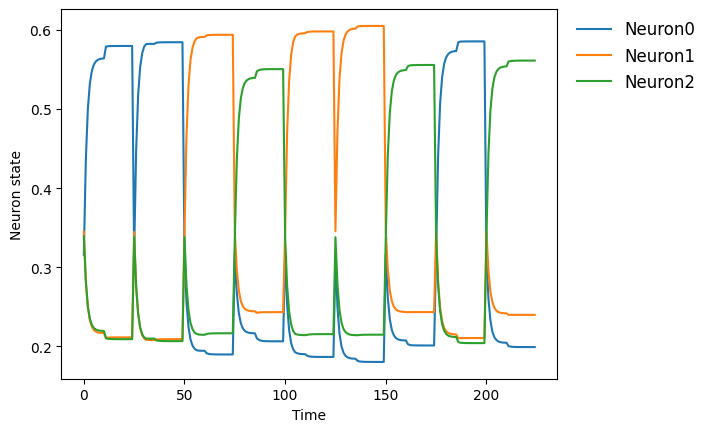

In [276]:
plot_evolution(train_output)

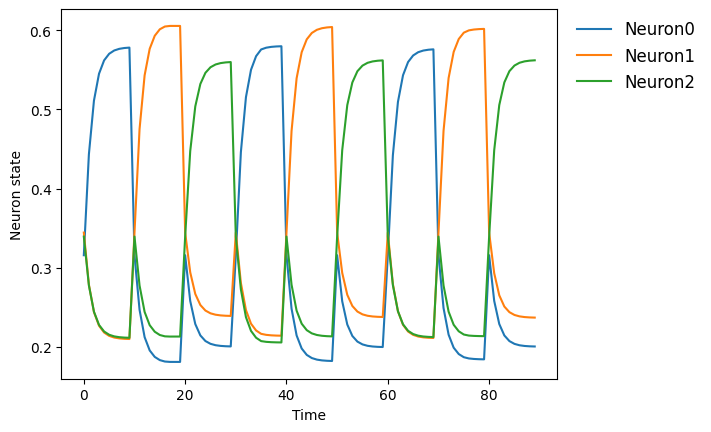

In [277]:
plot_evolution(test_output)

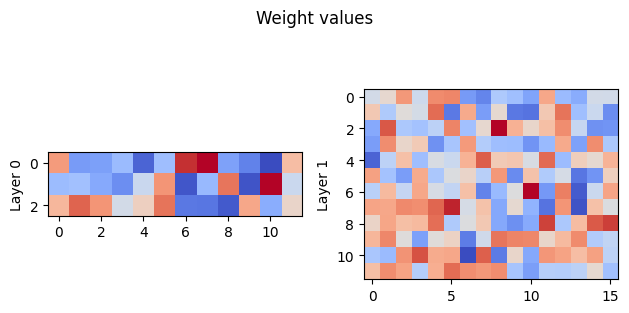

In [278]:
imshow_weight(net.W)

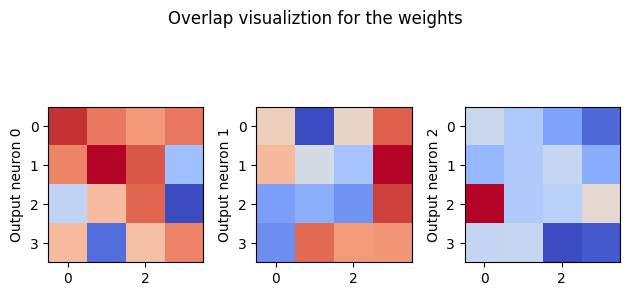

In [279]:
overlap_linear_weight(net.W, size_square, fcLayers[0])